In [1]:
!pip install  opencv-contrib-python==4.5.3.56
import numpy as np
import cv2
import os
import scipy
import matplotlib.pylab as plt
from skimage import io

In [2]:
def imshow_compare(img1, img2) :
    fig, axes = plt.subplots(1,2, figsize = (20,20))
    axes[0].imshow(img1)
    axes[1].imshow(img2)

def preprocessing(img) :
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (img, img_gray) 

(469, 347, 3)
(469, 347, 3)


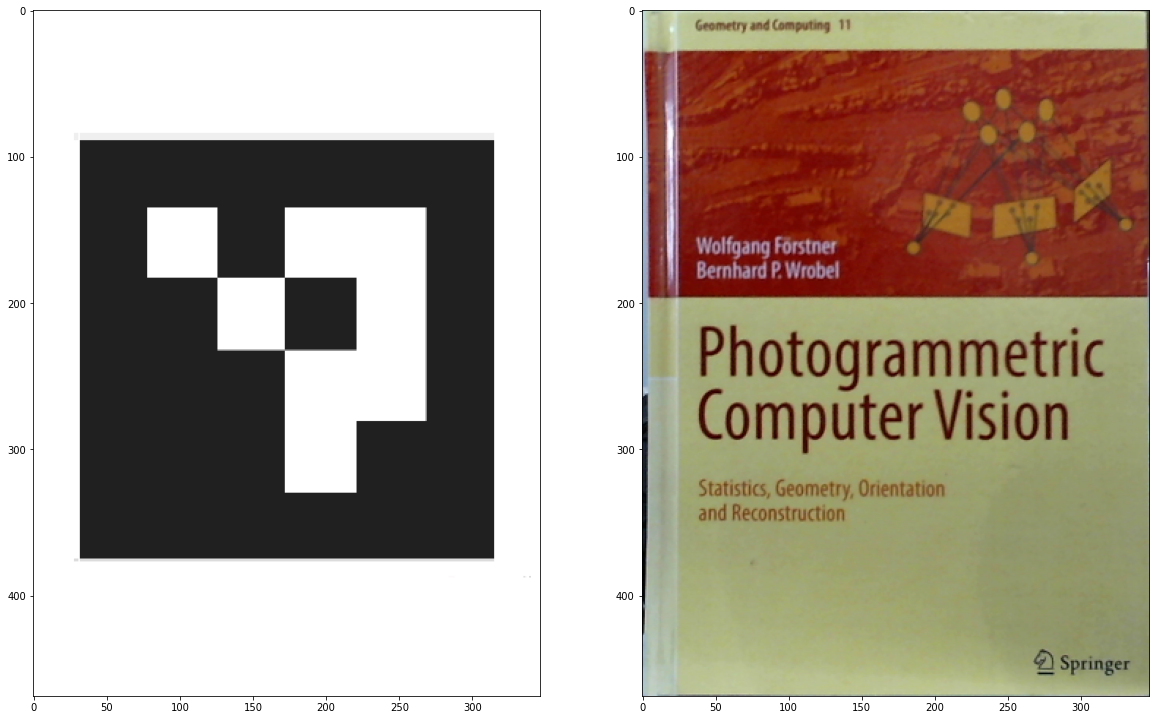

In [3]:
# นำภาพ Template และ ภาพ ArUco เข้ามา
# เก็บภาพ QRcode ไว้ใน QRC ขนาดเท่าหนังสือ 182*240 mm. หรือ 469*347 px แต่ ArUco ใช้ 150 mm.
QRC = cv2.imread('./images/QRCode2.png')

# เก็บภาพ หนังสือต้นแบบ ไว้ใน template 182*240 mm. หรือ 469*347 px
template = cv2.imread('./images/Template-3.png')
templatecopy = template.copy()

# แปลงจาก BGR เป็น RGB
template_img = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
templatecopy = cv2.cvtColor(templatecopy, cv2.COLOR_BGR2RGB)

# #แสดงผล
# imshow_compare(QRC, templatecopy)
# print(QRC.shape) #ปริ้นดูขนาด
# print(template_img.shape) #ปริ้นดูขนาด

In [4]:
###### สร้างฟังก์ชั่น AruCo_Warp_and_stitch เพื่อนำ QRcode ไปแปะที่หนังสือในวิดีโอ
def AruCo_Warp_and_stitch(video_2, QRC, H) : # Warp and stitch
    rows, cols = video_2.shape[:2]
    warped_img = cv2.warpPerspective(QRC, H, (2*cols, 2*rows))
    enlarge_ref_img = np.zeros((2*rows, 2*cols, 3), dtype=np.uint8)
    enlarge_ref_img[:rows, :cols] = video_2
    warped_gray = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)
    warped_mask = cv2.threshold(warped_gray, 0, 255, cv2.THRESH_BINARY)[1]
    segmented_ref_img = cv2.add(warped_img, enlarge_ref_img, mask=np.bitwise_not(warped_mask))
    result = cv2.add(segmented_ref_img, warped_img)

    grayscale = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    mask = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY)[1]
    # ค้นหาคอนทัวร์ภายในมาส์ก 
    contour, hier = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # รับคอนทัวร์ด้วยพื้นที่สูงสุด
    max_area_contour = max(contour, key=cv2.contourArea)

    # สร้างขอบกล่อง
    (x, y, w, h) = cv2.boundingRect(max_area_contour)
    
    # return กลับ
    return result[:h, :w]

In [5]:
######### ใช้ในขั้นตอนที่ 3 หาตำเหน่ง (X,Y,Z)
# โหลดค่า camera_params Calibration มาใช้
params_dir = os.getcwd()+'/new-camera_params_Final_examination/'
print(params_dir)

# ใช้ค่า K กับ ค่า dist
K = np.load(params_dir+'K.npy')
dist = np.load(params_dir+'dist.npy')

print("Camera matrix")
print(K)
print("Len distortion")
print(dist)

c:\Users\Admin\Desktop\Final_examination_Kritsada_Kunsiri\Final_Examination_Kritsada_Kunsiri/new-camera_params_Final_examination/
Camera matrix
[[726.47630281   0.         466.2575863 ]
 [  0.         732.06406134 251.99786765]
 [  0.           0.           1.        ]]
Len distortion
[[ 0.02450981  0.03012141  0.00045661  0.01036187 -0.07354295]]


In [6]:
######## กำหนดใช้ในขั้นตอนที่ 3 หาตำเหน่ง (X,Y,Z)
# นำเข้า arucoDictionary
AruCo_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
AruCo_params = cv2.aruco.DetectorParameters_create()

# (xกี่ตัว , กี่ตัว , ความยาวแต่ละด้าน , ,) ในกรณีนี้ใช้แค่ 1 ตัว ความยาวแต่ละด้านเท่าหนังสือ
board = cv2.aruco.GridBoard_create(1, 1, 0.150, 0.1, AruCo_dict) 

In [7]:
######## กำหนดใช้ในขั้นตอนที่ 3 ใช้แสดงตำเหน่ง (X,Y,Z)
def write_text_position(detected_video, pose, dy, text) :
    x0 = pose[0]
    y0 = pose[1]
    for i, line in enumerate(text.split('\n')) :
        y = y0 + i*dy
                                                             #( เปลี่ยน ฟร้อน, สี, ขนาด ตัวหนังสือ )
        cv2.putText(detected_video, line, np.int32([x0, y]), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0,255,0), 2)

In [9]:
def feature_matching_and_position_detection(video_device) :
    
    video = cv2.VideoCapture(video_device)
    video.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    video.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    ret, old_frame = video.read()
    # print(old_frame.shape)
    # old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    template = cv2.imread('./images/Template-3.png')
    template_img = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    # print(template.shape)
    template2 = template.copy()
    kernel = np.array([[0,-1,0],
                     [-1,8,-1],
                     [0,-1,0]],dtype=np.float32)
    template2 = cv2.filter2D(template2,-3,kernel)
    
    # วิดีโอเปิด
    while video.isOpened() : 
        ret, video_1 = video.read()
        ret, video_2 = video.read()
        
        # True
        if ret :
            
            query_video = video_1
            query_gray_video = cv2.cvtColor(video_1, cv2.COLOR_BGR2GRAY)
            
            # วิดีโอมีความละเอียดไม่มากทำให้การตรวจจับเกิดการผิดพลาดดังนั้นจึงทำการ ทำให้ภาพคมชัดขึ้น
            kernel = np.array([[0,0,0],
                   [0,1.7,0],
                   [0,0,0]],dtype=np.float32)
            query_gray_video = cv2.filter2D(query_gray_video,-3,kernel)
            
        ######################################################### ขั้นตอนที่ 1 ใช้ SIFT ตรวจจับหนังสือในวิดีโอ
            
            # กำหนด SIFT
            sift = cv2.SIFT_create() 

            # ใช้ BFMatcher ในการจับคู่ภาพ
            bf = cv2.BFMatcher()

            # จะเรียกใช้มัน คำสั่ง sift.detectAndCompute
            template_kpts, template_desc = sift.detectAndCompute(template_img, None)
            query_kpts, query_desc = sift.detectAndCompute(query_gray_video, None)

            # เอาพอยที่หาจากภาพและวิดีโอมา matc กัน
            matches = bf.knnMatch(template_desc, query_desc, k=2)

            # ได้ค่า good_matches เพื่อนำไป RANSAC 
            good_matches = list()
            good_matches_list = list()
            
            # หาคู่ที่โดดเด่น
            for m, n in matches :
                if m.distance < 0.57*n.distance :
                    good_matches.append(m)           
                    good_matches_list.append([m])
         
        ########################################################## ขั้นตอนที่ 2 ใช้ RANSAC หาคู่ matc ที่ดีที่สุดเพื่อความแม่นยำในการตรวจจับ
            
            # ตั้งเงื่อนไข good_matches น้อยกว่า 12
            if len(good_matches) > 12 :
                src_pts = np.float32([ template_kpts[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
                dst_pts = np.float32([ query_kpts[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

                H, inlier_masks = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 0.95) # H RANSAC

                # รับกรอบล้อมรอบภาพเทมเพลต สีแดง 
                h, w = template_img.shape[:2]

                # วาด กล่องสีแดงครอบหนังสือที่จับเจอ
                template_box = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1,1,2) 
                transformed_box = cv2.perspectiveTransform(template_box, H)
                
                # นำตัวVDO detected_video ไปใช้ต่อในการจับหาตำแหน่ง (X,Y,Z)
                detected_video = cv2.polylines(query_video, [np.int32(transformed_box)], True, (0,0,255), 2, cv2.LINE_AA)

                # drawmatch_img แสดงการจับกันของคู่แมทต์ ลากเส้นหากัน 
                #drawmatch_img = cv2.drawMatchesKnn(template_img, template_kpts, detected_video, query_kpts, good_matches_list, None, flags=2, matchesMask=inlier_masks)

                # เรียกใช้ฟังก์ชั้น AruCo_Warp_and_stitch จะวาปภาพ QRC เข้าไปทับหนังสือในวิดีโอ video_2 ใช้เพื่อหาตำแหน่ง (X,Y,Z)
                result = AruCo_Warp_and_stitch(video_2, QRC, H) 

                # copy วิดีโอ result เก็บไว้ใน result2 นำไปใช้ขั้นตอนต่อไป
                result2 = result.copy()
            
        ########################################################## ขั้นตอนที่ 3 ใช้ ArUco หาตำเหน่ง (X,Y,Z) ของหนังสือในวิดีโอ
            
            # ใช้ cv2.aruco.detectMarkers โยน วิดีโอเข้าไป , AruCo_dict , parameters
            # ได้มุม , id
            markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(result, AruCo_dict, parameters = AruCo_params)
            
            # ถ้า markerCorners มากกว่า 0 คือถ้าเจอ aruco
            if len(markerCorners) > 0:

                # cv2.aruco.drawDetectedMarkers วาด ตัว Markers ลงไปในวิดีโอ
                result2 = cv2.aruco.drawDetectedMarkers(result, markerCorners)
                
                # cv2.aruco.estimatePoseSingleMarkers ได้ rvecs มุมการหมุน ,  tvecs ตำแหน่ง , points จุดที่เจอ
                rvecs, tvecs, points = cv2.aruco.estimatePoseSingleMarkers(markerCorners , 0.150, K, dist) # 0.182 ขนาด aruco บนหนังสือ
                for (rvec, tvec, id, corner) in zip(rvecs, tvecs, markerIds, markerCorners) :
                    #detected_img = cv2.aruco.drawAxis(detected_img, K, dist, rvec, tvec, 0.182)
                    x = tvec[0,0]
                    y = tvec[0,1]
                    z = tvec[0,2]
                    text = "pose: X:{:.1f} Y:{:.1f} Z:{:.1f}".format(x, y, z)
                    cX = (corner[0,0][0] + corner[0,2][0]) / 2
                    cY = (corner[0,0][1] + corner[0,2][1]) / 2
                    write_text_position(detected_video, (cX, cY), 20, text)
                ret, brvec, btvec = cv2.aruco.estimatePoseBoard(markerCorners, markerIds, board, K, dist, rvecs, tvecs) 
                if ret :
                    result2 = cv2.aruco.drawAxis(result, K, dist, brvec, btvec, 0.05)
           
                    
            #cv2.imshow('Video frame', result2 ) # ดู aruco ที่ถูกติดกับหนังสือในวิดีโอ
            #cv2.imshow('Video frame', drawmatch_img) # ดู matching

            cv2.imshow('Video frame', detected_video)

            # ถ้ากด q ทำการปิดวิดีโอที่เล่นอยู่
            if cv2.waitKey(int(1000/24)) & 0xFF == ord('q') :
                break
        else :
            break
    video.release()
    cv2.destroyAllWindows()
    
feature_matching_and_position_detection('./videos/final_exam/Dataset-1/left_output-1.avi') # ใช้วิดีโอจากมุมกล้องซ้าย